# This notebook:
### 1. Splits the dataset into two subsets by year.
### 2. Clusters the beached points with the HDBSCAN clustering method from scikit-learn for each temporal subset by latitude and longitude of beached points
#### Clustering algorithm HDPSCAN: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html
### 3. Details cluster-selection process
### 4. Plots density contours for the resulting clusters
### 5. Compares any temporal change

In [2]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [3]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

from sklearn.preprocessing import MinMaxScaler
import hdbscan

In [4]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

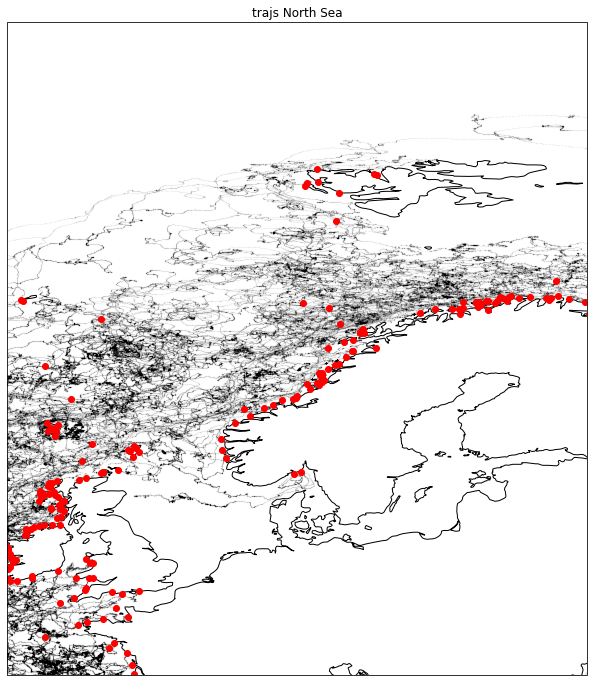

In [244]:
# get beach points for beach lat/lon
beaching_points = beach.drop_duplicates(subset='id', keep='last')

point_size = 0.0005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 30, 45, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    s=point_size,
    alpha=0.7
)

plt.scatter(beaching_points['lon'], beaching_points['lat'], color = 'r')



plt.title('trajs North Sea')

plt.show()

#### Let's start by splitting the dataset into two temporal subsets. The time feature of the dataset is in seconds since 1970-01-01, so let's visualize the number of data in each year

Text(0, 0.5, 'count')

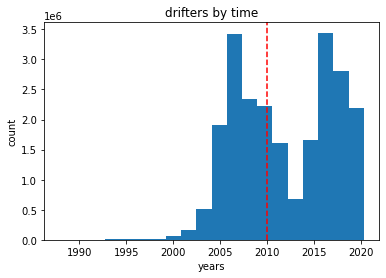

In [117]:
plt.hist(1970 + beach['time'] / 60 / 60 / 24 / 365, bins = 20)
plt.axvline(x=2010, color='red', linestyle='--')
plt.title('drifters by time')
plt.xlabel('years')
plt.ylabel('count')

### Unfortunately, we can't simply take the first 16 or so years of data because there is so little. Let's consider all data before 2010 as 'old' and all data after 2010 as 'new.' This will result in analysis of change from before and after 2010 while allowing for a sizeable amount of data for both 'old' and 'new'

In [114]:
# let's make two subsets of the original dataset, splitting them into equal halves
split_by = (2010 - 1970) * 60 * 60 * 24 * 365

traj_end = beach.drop_duplicates(subset='id', keep='last') # will split by whether their last point is greater than 2004 or not
beach_new_traj = traj_end[traj_end['time'] > split_by]
beach_old_traj = traj_end[traj_end['time'] <= split_by]

# get all points in traj
# Get unique IDs from beach_new_traj and beach_old_traj
ids_to_filter = beach_new_traj['id'].tolist() + beach_old_traj['id'].tolist()

# Filter beach DataFrame for the unique IDs
beach_filtered = beach[beach['id'].isin(ids_to_filter)]

# Separate filtered data into beach_new and beach_old based on IDs
beach_new = beach_filtered[beach_filtered['id'].isin(beach_new_traj['id'])]
beach_old = beach_filtered[beach_filtered['id'].isin(beach_old_traj['id'])]

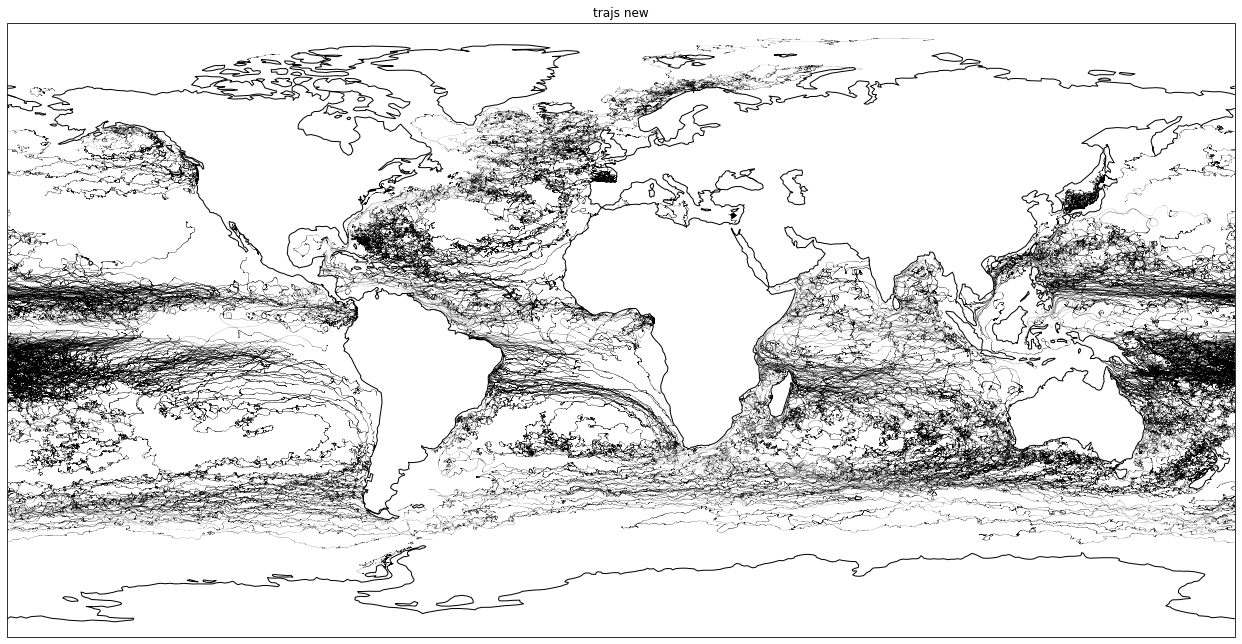

In [118]:
point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_old['lon'],
    beach_old['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    s=point_size,
    alpha=0.7
)




plt.title('trajs old')

plt.show()

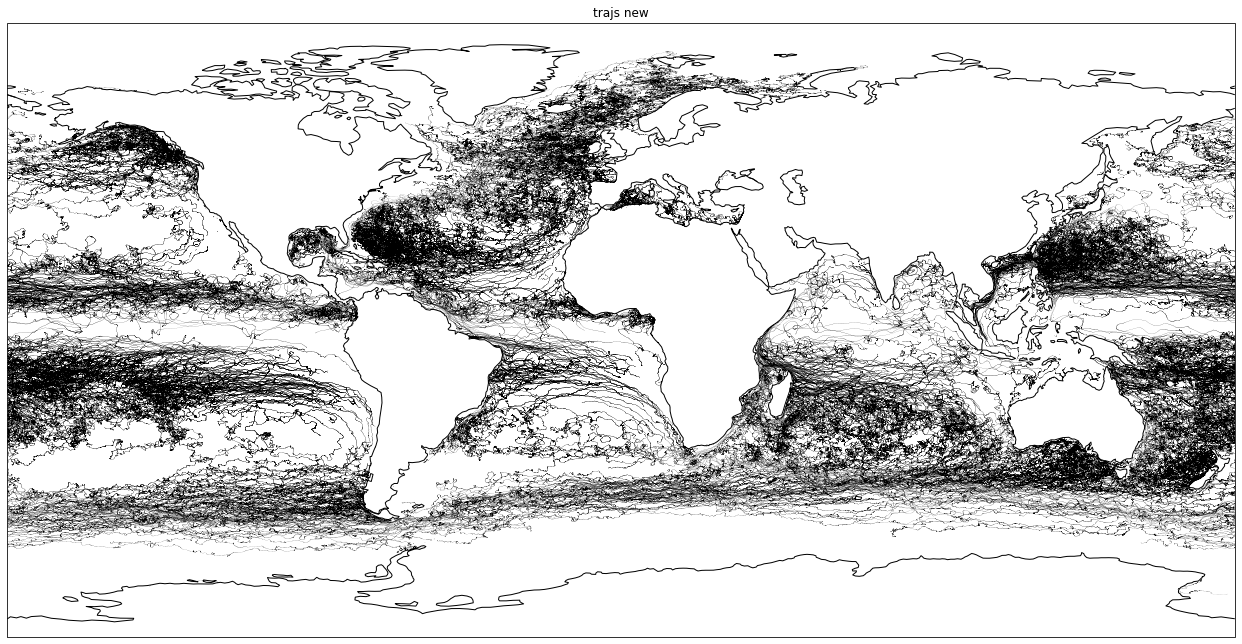

In [119]:
point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_new['lon'],
    beach_new['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    s=point_size,
    alpha=0.7
)




plt.title('trajs new')

plt.show()

In [229]:
# get beach points for beach lat/lon
last_points_input = beach_old.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 8) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 20:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [230]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN

# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 40, # minimum number beach points in a cluster
    cluster_selection_epsilon = 2) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

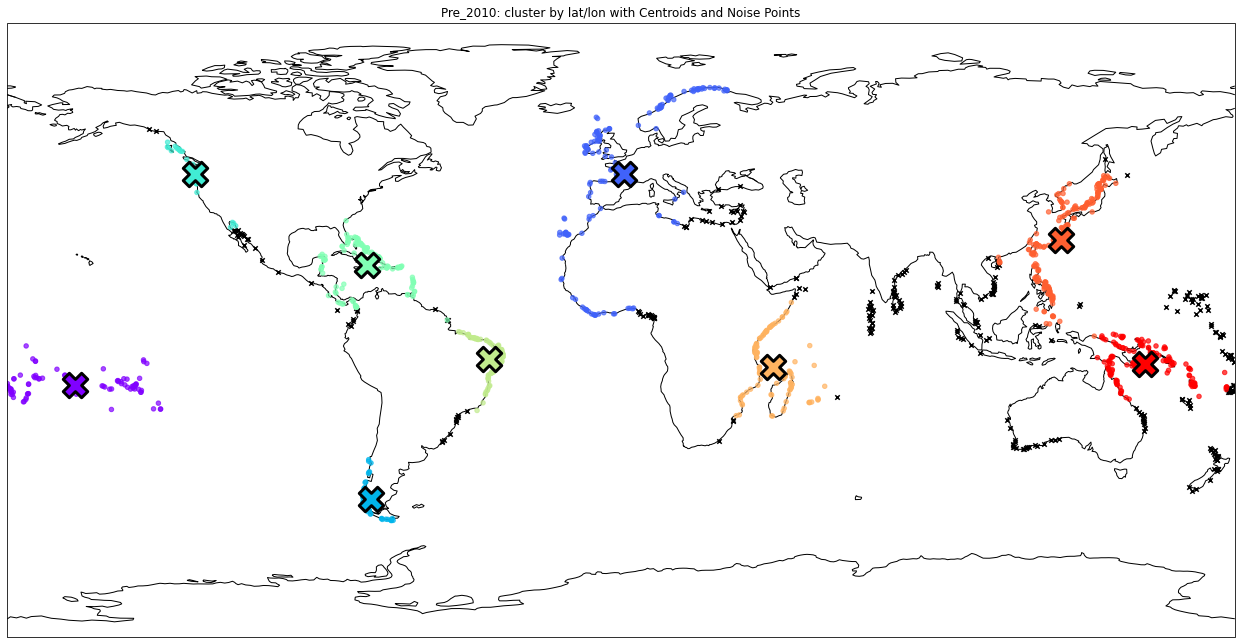

In [231]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pre_2010: cluster by lat/lon with Centroids and Noise Points')
plt.show()

In [232]:
unique_labels_figure1 = np.unique(cluster_df['HDBSCAN'])

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/2)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

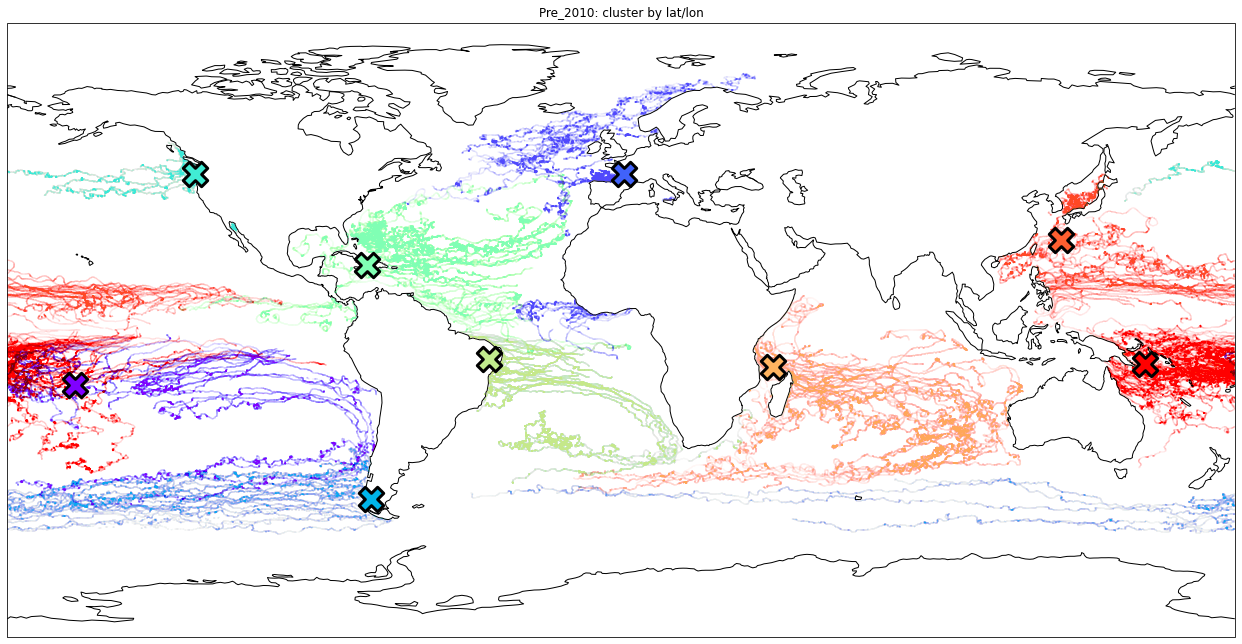

In [233]:
# Plotting code for the second figure

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('Pre_2010: cluster by lat/lon')

plt.show()

In [234]:
# get beach points for beach lat/lon
last_points_input = beach_new.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 8) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 20:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [235]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN

# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 40, # minimum number beach points in a cluster
    cluster_selection_epsilon = 2) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

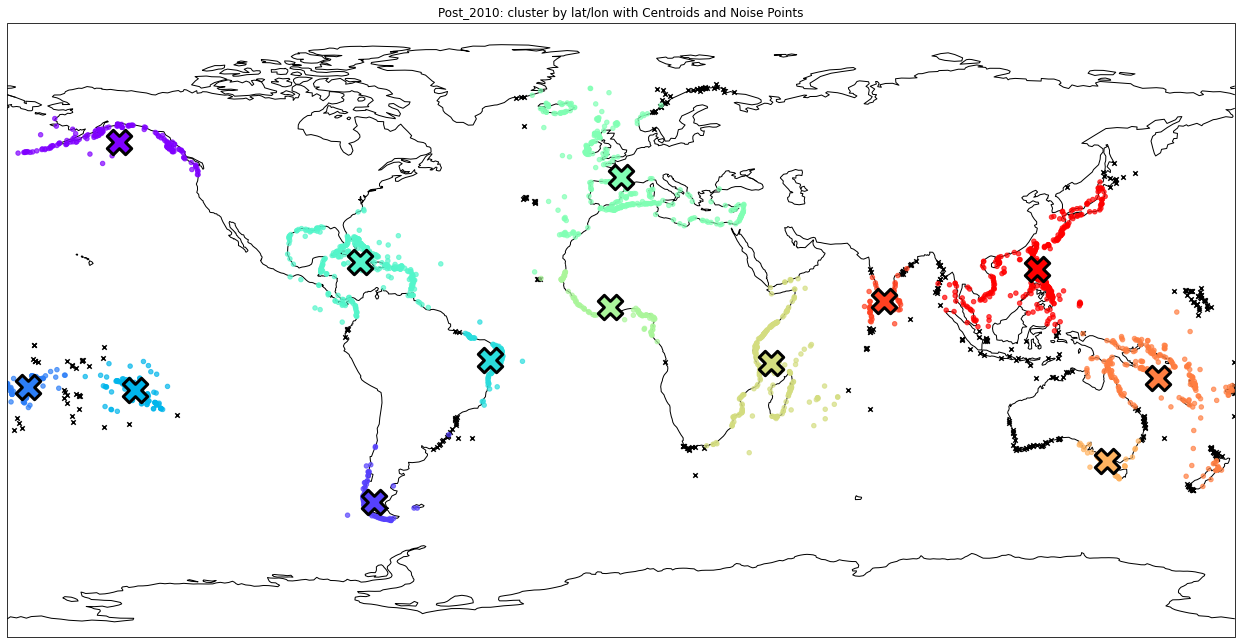

In [237]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Post_2010: cluster by lat/lon with Centroids and Noise Points')
plt.show()

In [238]:
unique_labels_figure1 = np.unique(cluster_df['HDBSCAN'])

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/2)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

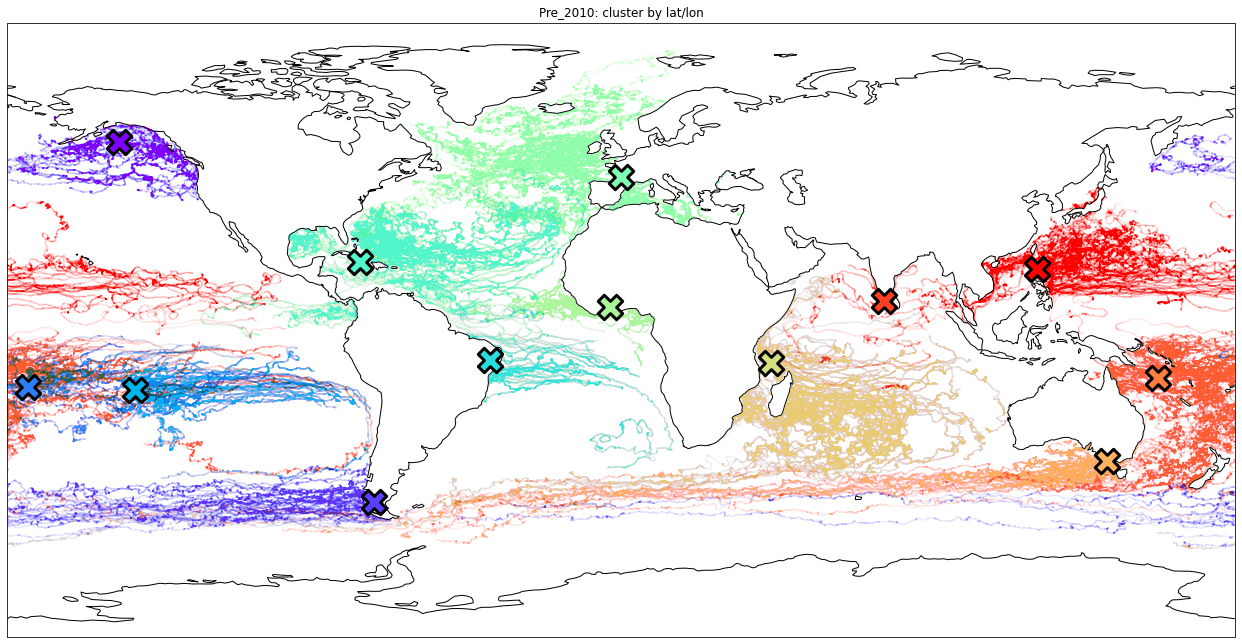

In [239]:
# Plotting code for the second figure

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('Post_2010: cluster by lat/lon')

plt.show()